In [1]:
## Main
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Torch
import torch
from torch import nn
from torch.optim import Adam, RMSprop
from torch.distributions.beta import Beta
from torch.distributions.chi2 import Chi2
from torch.distributions.normal import Normal
from torch.distributions.studentT import StudentT
from torch.distributions.multivariate_normal import MultivariateNormal

## OT
import ot
from ot import wasserstein_1d
from ot import sinkhorn, sinkhorn2

## Own code
import sys
sys.path.append('../')
from src.torch import SinkhornLayer, WeightClipper
import src.utils as utils 

from IPython.core.display import HTML
_ = HTML(\
     """
        <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
        </style>
    """
)

config = utils.get_config()

<Figure size 432x288 with 0 Axes>

## Distributions Experiments

After seeing the way the differents schemes worked on simple Gaussian distributions we will see how they behave on more complexe distributions like :

 - Studient
 - Chi2
 - Beta
 
We have used the same set up for training and validation as in the main wasser.ipynb. The results after the dotted line represent the validation part of dataset.

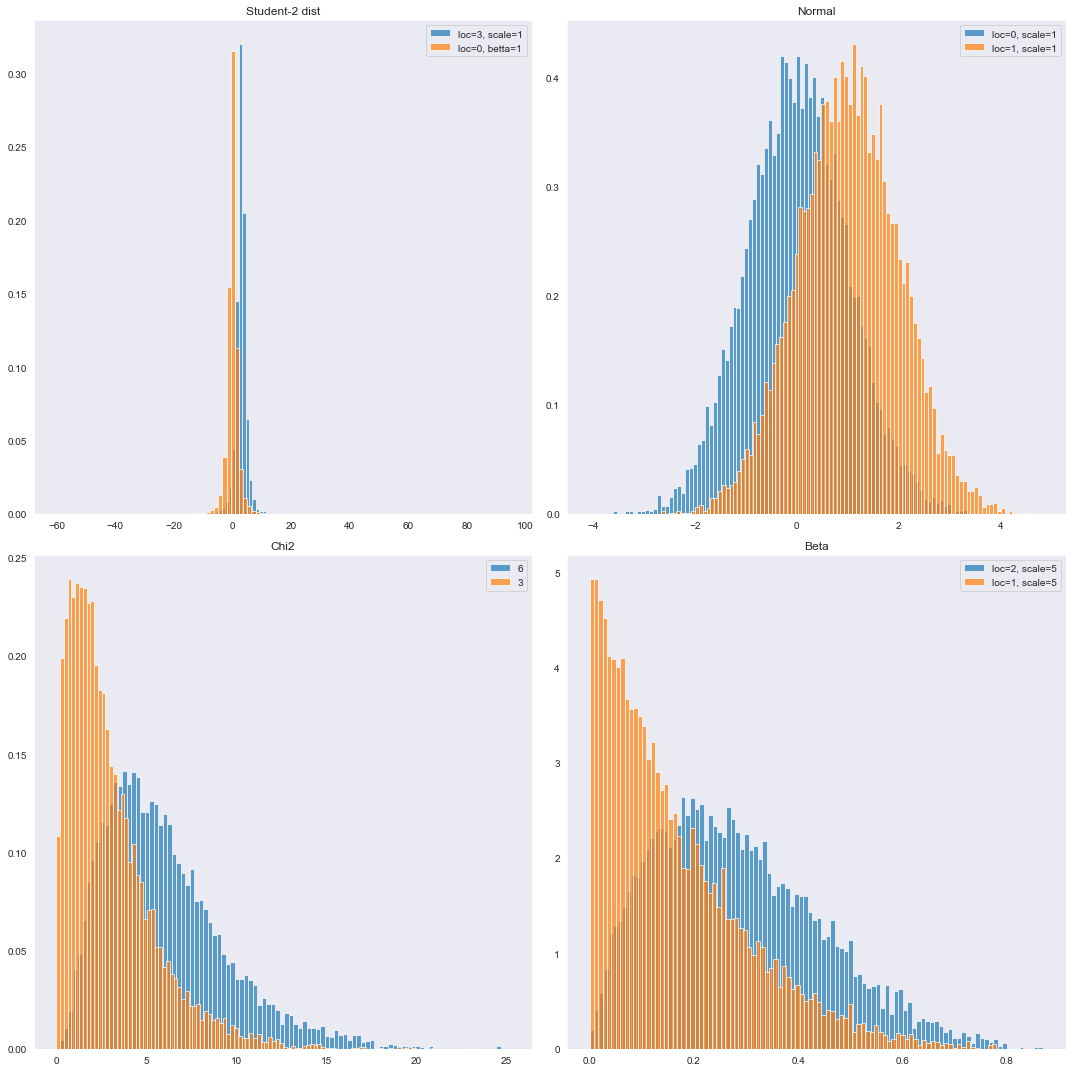

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))


dist = StudentT(2, 3, 1)
_ = axs[0, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=3, scale=1")
dist = StudentT(2, 0, 1)
_ = axs[0, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=0, betta=1")
axs[0, 0].legend()
axs[0, 0].set_title("Student-2 dist")

dist = Normal(0, 1)
_ = axs[0, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=0, scale=1")
dist = Normal(1, 1)
_ = axs[0, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=1, scale=1")
axs[0, 1].legend()
axs[0, 1].set_title("Normal")

dist = Chi2(6)
_ = axs[1, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="6")
dist = Chi2(3)
_ = axs[1, 0].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="3")
axs[1, 0].legend()
axs[1, 0].set_title("Chi2")

dist = Beta(2, 5)
_ = axs[1, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=2, scale=5")
dist = Beta(1, 5)
_ = axs[1, 1].hist(dist.sample((10000, )).numpy(), density=True, bins=100, alpha=0.7, label="loc=1, scale=5")
axs[1, 1].legend()
axs[1, 1].set_title("Beta")


plt.tight_layout()  
plt.show()

In [3]:
# Creation of list and dict to automate the training
dist_names = ["Student-2", 
              "Normal", 
              "Beta", 
              "Chi2"]
model_names = ["WGANGP", 
               "WGANClip", 
               "WGANc", 
               "WGANc_eps", 
               "Sinkhorn"]
dist_map = {
    "Student-2":{
        "1": StudentT(df=2, loc=3, scale=1),
        "2": StudentT(df=2, loc=0, scale=1),
    },
    "Normal":{
        "1": Normal(loc=1, scale=1),
        "2": Normal(loc=0, scale=1)
    },
    "Beta":{
        "1": Beta(concentration1=3, concentration0=5),
        "2": Beta(concentration1=1, concentration0=5)
    },
    "Chi2":{
        "1": Chi2(df=6),
        "2": Chi2(df=3)
    }
}

## Models

For each distribution and scheme we create a model.

#### WGAN Clip

In [4]:
clipper = WeightClipper(config['c_Clip'])
netD_Clip_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(config["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(config["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_Clip_map = dict(zip(dist_names, [RMSprop(
                                               netD_Clip_map[name].parameters(),
                                               lr=config["lr_Clip"]
                                            ) for name in dist_names
                                        ]
                                    )
                                )

#### WGAN Gradient Penalty

In [5]:
netD_GP_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(config["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(config["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_GP_map = dict(zip(dist_names, [Adam(
                                            netD_GP_map[name].parameters(),
                                            lr=config["lr_GP"],
                                            betas=config["betas_GP"]
                                        ) for name in dist_names
                                     ]
                                )
                            )

#### $(c)$-GAN

In [6]:
netD_C_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(config["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(config["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_C_map = dict(zip(dist_names, [RMSprop(
                                           netD_C_map[name].parameters(),
                                           lr=config["lr_c"]
                                        ) for name in dist_names
                                    ]
                                )
                            )

#### $(C, \epsilon)$-GAN

In [7]:
eps=1
netD_C_eps_map = dict(zip(dist_names, [nn.Sequential(
                                            nn.Linear(config["batch_size_dist"][1], 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 1)
                                        ).to(config["device"]) for name in dist_names
                                    ]
                                )
                            )

optimD_C_eps_map = dict(zip(dist_names, [RMSprop(
                                           netD_C_eps_map[name].parameters(),
                                           lr=config["lr_c_eps"]
                                        ) for name in dist_names
                                    ]
                                )
                            )

#### Sinkhorn

In [8]:
sinkhorn = SinkhornLayer(eps=config["Sinkhorn_eps"])

#### Training

In [9]:
losses = {
    "Student-2": dict(zip(model_names, [ [] for _ in model_names ])),
    "Normal": dict(zip(model_names, [ [] for _ in model_names ])),
    "Beta": dict(zip(model_names, [ [] for _ in model_names ])),
    "Chi2": dict(zip(model_names, [ [] for _ in model_names ])),
}

for epoch in (pbar := tqdm(range(config["train_epoches"]))):
    for dist_name in dist_names:
        X_1_batch = dist_map[dist_name]["1"].rsample(config["batch_size_dist"]).to(config['device'])
        X_2_batch = dist_map[dist_name]["2"].rsample(config["batch_size_dist"]).to(config['device'])

        ### WGANClip
        optimD_Clip_map[dist_name].zero_grad()
        e_X_1 = netD_Clip_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_Clip_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip_map[dist_name].step()

        netD_Clip_map[dist_name].apply(clipper)
        losses[dist_name]["WGANClip"].append(netD_loss.item())

        ### WGANGP
        optimD_GP_map[dist_name].zero_grad()
        e_X_1 = netD_GP_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_GP_map[dist_name](X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 

        mix_alpha = torch.rand((len(X_1_batch), 1), device=config['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD_GP_map[dist_name](mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - config['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP_map[dist_name].step()

        losses[dist_name]["WGANGP"].append(netD_loss.item())

        ### WGAN (c)
        optimD_C_map[dist_name].zero_grad()
        phi_X_1 = netD_C_map[dist_name](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_map[dist_name].step()
        losses[dist_name]["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        optimD_C_eps_map[dist_name].zero_grad()
        phi_X_1 = netD_C_eps_map[dist_name](X_1_batch)
        phi_X_2 = -config["(c,eps)_eps"]*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/config["(c,eps)_eps"])*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps_map[dist_name].step()
        losses[dist_name]["WGANc_eps"].append(netD_loss.item())


        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses[dist_name]["Sinkhorn"].append((P*C).sum().item())

    
for epoch in (pbar := tqdm(range(config["val_epoches"]))):
    for dist_name in dist_names:
        X_1_batch = dist_map[dist_name]["1"].rsample(config["batch_size_dist"]).to(config['device'])
        X_2_batch = dist_map[dist_name]["2"].rsample(config["batch_size_dist"]).to(config['device'])

        ### WGANClip
        optimD_Clip_map[dist_name].zero_grad()
        e_X_1 = netD_Clip_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_Clip_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        netD_Clip_map[dist_name].apply(clipper)
        losses[dist_name]["WGANClip"].append(netD_loss.item())

        ### WGANGP
        optimD_GP_map[dist_name].zero_grad()
        e_X_1 = netD_GP_map[dist_name](X_1_batch).mean()
        e_X_2 = netD_GP_map[dist_name](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        losses[dist_name]["WGANGP"].append(netD_loss.item())

        ### WGAN (c)
        optimD_C_map[dist_name].zero_grad()
        phi_X_1 = netD_C_map[dist_name](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)
        netD_loss = phi_X_1.mean() + phi_X_2.mean()
        losses[dist_name]["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        optimD_C_eps_map[dist_name].zero_grad()
        phi_X_1 = netD_C_eps_map[dist_name](X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )
        netD_loss = phi_X_1.mean() + phi_X_2.mean()
        losses[dist_name]["WGANc_eps"].append(netD_loss.item())


        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses[dist_name]["Sinkhorn"].append((P*C).sum().item())
            
losses_dist = losses

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

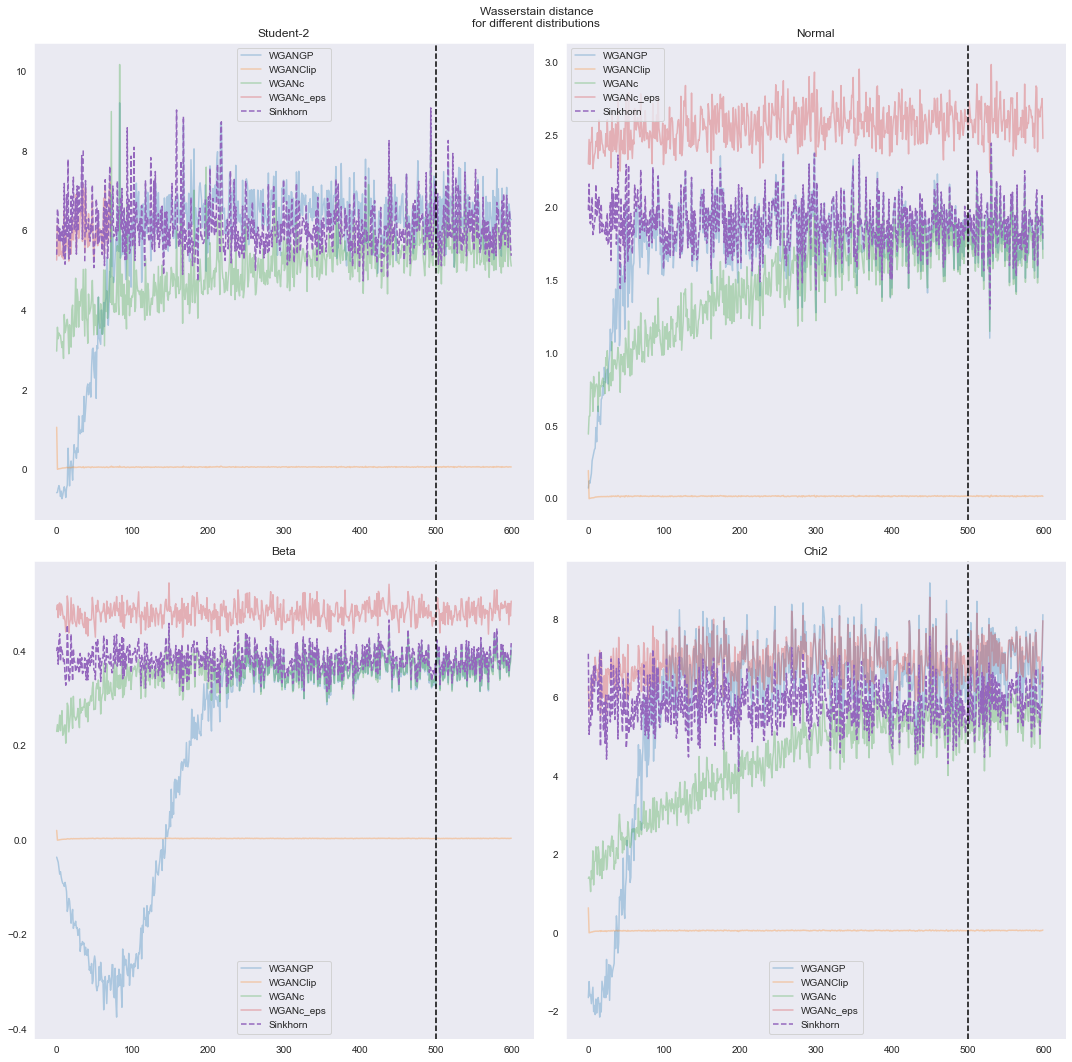

In [10]:
values = list(losses.values())
keys = list(losses.keys())

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("Wasserstain distance\nfor different distributions")
for i, ax in enumerate(axs.flatten()):
    ax.set_title(keys[i])
    for key, item in values[i].items():
        alpha = 1 if key == "Sinkhorn" else 0.3
        linestyle = "--" if key == "Sinkhorn" else None
        ax.plot(item, label=key, alpha=alpha, linestyle=linestyle)
    ax.axvline(config["train_epoches"], c="black", linestyle="--")
    ax.legend()
      
plt.tight_layout()  
plt.show()

This experiment shows us multiple things:

 - the *Weight Clip* never comes close to the real distance.
 - the *$c$-transfrom* is always the closest with *GP*.
 - the *$(c, \epsilon)$-transform* is often bigger than the others

### Layer Width influence

Until now we only used MLP with hidden layers of size 128. Lets see what happen when we changed the size of thoses layers.

Here we will use mulitvariate Gaussian distribution of size 3.

In [11]:
mean1 = torch.arange(config["batch_size_dist"][1], dtype=torch.float32)
cov1_tril = torch.tril(torch.rand((config["batch_size_dist"][1], config["batch_size_dist"][1])))
cov1 = cov1_tril@cov1_tril.T

mean2 = torch.arange(config["batch_size_dist"][1], config["batch_size_dist"][1]*2, dtype=torch.float32)
cov2_tril = torch.tril(torch.rand((config["batch_size_dist"][1], config["batch_size_dist"][1])))
cov2 = cov2_tril@cov2_tril.T

dist1 = MultivariateNormal(mean1, cov1)
dist2 = MultivariateNormal(mean2, cov2)

In [12]:
layer_width = [16, 32, 64, 128, 256, 512]

#### WGAN Clip

In [13]:
clipper = WeightClipper(config["c_Clip"])
netD_Clip_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(config["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(config["device"]) for width in layer_width]
                            )
                        )

optimD_Clip_map = dict(zip(layer_width, [RMSprop(
                                   netD_Clip_map[width].parameters(),
                                   lr=config["lr_Clip"]
                                ) for width in layer_width]
                            )
                        )

#### WGAN Gradient Penalty

In [14]:
netD_GP_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(config["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(config["device"]) for width in layer_width]
                            )
                        )

optimD_GP_map = dict(zip(layer_width, [Adam(
                                    netD_GP_map[width].parameters(),
                                    lr=config["lr_GP"],
                                    betas=config["betas_GP"]
                                ) for width in layer_width]
                            )
                        )

#### $(c)$-GAN

In [15]:
netD_C_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(config["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(config["device"]) for width in layer_width]
                            )
                        )

optimD_C_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_map[width].parameters(),
                                   lr=config["lr_c"]
                                ) for width in layer_width]
                            )
                        )

#### $(C, \epsilon)$-GAN

In [16]:
eps=1
netD_C_eps_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(config["batch_size_dist"][1], width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(config["device"]) for width in layer_width]
                            )
                        )

optimD_C_eps_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_eps_map[width].parameters(),
                                   lr=config["lr_c_eps"]
                                ) for width in layer_width]
                            )
                        )

#### Sinkhorn

In [17]:
sinkhorn = SinkhornLayer(eps=config["Sinkhorn_eps"])

#### Experiments

In [18]:
config["train_epoches"] = 1000

losses = {
    "WGANGP": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANClip": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc_eps": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "Sinkhorn": [],
}

for epoch in (pbar := tqdm(range(config["train_epoches"]))):
    X_1_batch = dist1.rsample(config["batch_size"]).to(config['device'])
    X_2_batch = dist2.rsample(config["batch_size"]).to(config['device'])

    ### WGANClip
    for width in layer_width:
        optimD_Clip_map[width].zero_grad()
        e_X_1 = netD_Clip_map[width](X_1_batch).mean()
        e_X_2 = netD_Clip_map[width](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip_map[width].step()

        netD_Clip_map[width].apply(clipper)
        losses["WGANClip"][width].append(netD_loss.item())

    ### WGANGP
    for width in layer_width:
        optimD_GP_map[width].zero_grad()
        e_X_1 = netD_GP_map[width](X_1_batch).mean()
        e_X_2 = netD_GP_map[width](X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 

        mix_alpha = torch.rand((len(X_1_batch), 1), device=config['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD_GP_map[width](mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - config['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP_map[width].step()

        losses["WGANGP"][width].append(netD_loss.item())

    ### WGAN (c)
    for width in layer_width:
        optimD_C_map[width].zero_grad()
        phi_X_1 = netD_C_map[width](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_map[width].step()
        losses["WGANc"][width].append(netD_loss.item())
    
    ### WGAN (c, eps)
    for width in layer_width:
        optimD_C_eps_map[width].zero_grad()
        phi_X_1 = netD_C_eps_map[width](X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps_map[width].step()
        losses["WGANc_eps"][width].append(netD_loss.item())


    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=2)
        a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
for epoch in (pbar := tqdm(range(config["val_epoches"]))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(config["batch_size"]).to(config['device'])
        X_2_batch = dist2.rsample(config["batch_size"]).to(config['device'])

        ### WGANClip
        for width in layer_width:
            e_X_1 = netD_Clip_map[width](X_1_batch).mean()
            e_X_2 = netD_Clip_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANClip"][width].append(netD_loss.item())

        ### WGANGP
        for width in layer_width:
            e_X_1 = netD_GP_map[width](X_1_batch).mean()
            e_X_2 = netD_GP_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANGP"][width].append(netD_loss.item())

        ### WGAN (c)
        for width in layer_width:
            phi_X_1 = netD_C_map[width](X_1_batch)
            phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)
            netD_loss = phi_X_1.mean() + phi_X_2.mean() 
            losses["WGANc"][width].append(netD_loss.item())

        ### WGAN (c, eps)
        for width in layer_width:
            optimD_C_eps_map[width].zero_grad()
            phi_X_1 = netD_C_eps_map[width](X_1_batch)
            phi_X_2 = -eps*torch.log(
                                    torch.mean(
                                        torch.exp(
                                            -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                        ), 
                                    1, keepdims=True)
                                )
            netD_loss = phi_X_1.mean() + phi_X_2.mean()
            losses["WGANc_eps"][width].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())
            
losses_width = losses

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

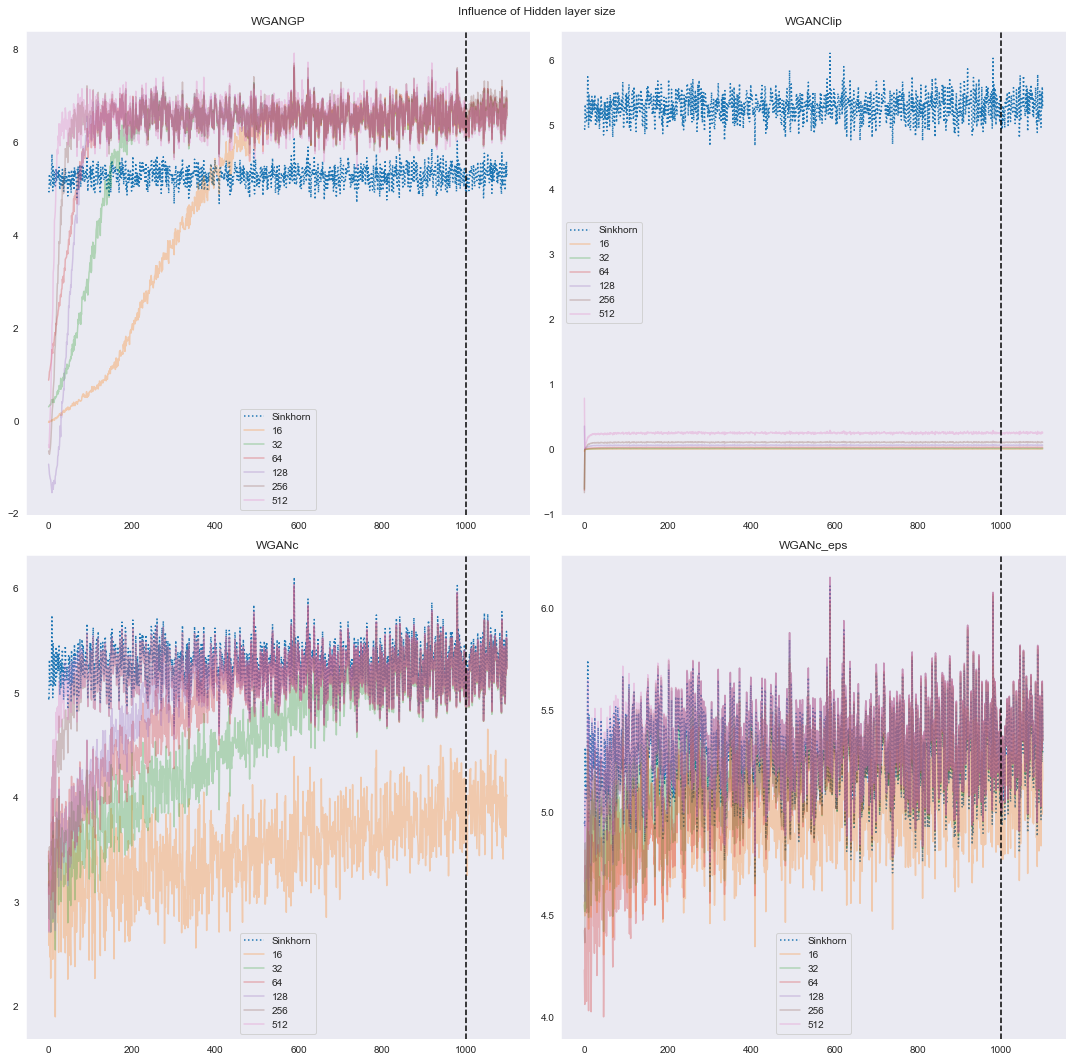

In [19]:
values = list(losses.values())
keys = list(losses.keys())

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("Influence of Hidden layer size")
for i, ax in enumerate(axs.flatten()):
    ax.set_title(keys[i])
    ax.plot(losses["Sinkhorn"], label="Sinkhorn", linestyle = ":")
    for key, item in values[i].items():
        ax.plot(item, label=key, alpha=0.3)
    ax.axvline(config["train_epoches"], c="black", linestyle="--")
    ax.legend()
plt.tight_layout()
plt.show()

What we observe is that the convergence rate of each MLP depends on its size.

 - for *GP* the largest the quickest it is to converge.
 - for *Cliping* we also see this phenomenon but the value it converges to is very far from the real value.
 - for *$c$-transfrom* at first making the hidden layer bigger makes the model converges slower but then the opposit is true.
 - for *$(c, \epsilon)$-transform*, the size of the MLP do affect the convergence to a lesser effect.